In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg
from skimage import io, color,transform
from skimage.filters import gaussian
import matplotlib.path as plt_path
import cv2
import math
import json
import mediapipe as mp

In [2]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 6))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

def crop(img:np.ndarray,top_left_coord:tuple,width:int,height:int):
                return img[max(top_left_coord[1],0):min(top_left_coord[1] + height,img.shape[1]),
                                max(top_left_coord[0],0):min(top_left_coord[0] + width,img.shape[0]), :]

In [4]:
# config: make oval crop before snake algorithm?
oval_crop = True

input_dir = './batch_dimi2/resized/'
output_dir = './batch_dimi2/processed/'
log_dir = './batch_dimi2/logs/'
MASK_COLOR = (255, 255, 255) # white

with open('./batch_dimi2/guide_data.json') as raw_file:
    with mp.solutions.selfie_segmentation.SelfieSegmentation(model_selection=0) as selfie_segmentation:

        guide_data = json.load(raw_file)

        for el in guide_data:
            # print(el)
            image_cv2 = cv2.imread(f'{input_dir}{el["filename"]}',cv2.IMREAD_UNCHANGED)
            image_rgba = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2RGBA)
            # print(image_rgba.shape)

            results = selfie_segmentation.process(cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB))

            smoothed_mask = cv2.bilateralFilter(results.segmentation_mask,50,350,350)

            # Draw selfie segmentation on the background image.
            # To improve segmentation around boundaries, consider applying a joint
            # bilateral filter to "results.segmentation_mask" with "image".
            # condition returns true for foreground
            condition = np.stack((smoothed_mask,) * 4, axis=-1) > 0.5 # default 0.1

            # Generate solid color images for showing the output selfie segmentation mask.
            fg_image = np.zeros(image_cv2.shape, dtype=np.uint8)
            fg_image[:] = MASK_COLOR
            bg_image = np.zeros(image_rgba.shape, dtype=np.uint8)
            # bg_image[:,:,:3] = BG_COLOR
            # bg_image[:,:,3] = 0

            output_image = np.where(condition, image_rgba, bg_image)
            cv2.imwrite('batch_2/temp.png', output_image)

            #start skimage processing
            image_rgba = io.imread('batch_2/temp.png')
            image_gray = color.rgb2gray(color.rgba2rgb(image_rgba))
            
            s = np.linspace(0, 2*np.pi, 400)
            c = el['x'] + el['xRad']*np.cos(s)
            r = el['y'] + el['yRad']*np.sin(s)
            points = np.array([r, c]).T 
            
            if oval_crop:
                oval_path = plt_path.Path(points)

                coords = np.zeros((image_gray.size,2))
                for j in range(image_gray.shape[1]):
                    for i in range(image_gray.shape[0]):
                        coords[i+j*image_gray.shape[0]][0] = i
                        coords[i+j*image_gray.shape[0]][1] = j

                bool_array = oval_path.contains_points(coords)

                png = np.copy(image_rgba)
                for j in range(png.shape[1]):
                    for i in range(png.shape[0]):
                        if bool_array[i+j*png.shape[0]] ==  False:
                            png[i,j,3] = 0
                
                image_rgba = png

            

            # fig, ax = image_show(image_gray)
            # ax.plot(points[:, 1], points[:, 0], '--r', lw=3)

            beta = 50
            alpha = 0.01

            snake = seg.active_contour(gaussian(image_gray, 4, preserve_range=False),
                       points, alpha=0.005, beta=0.001, gamma=0.001)
            # snake = seg.active_contour(image_gray, points, alpha=alpha, beta=beta, gamma=0.001)

            fig, ax = image_show(image_rgba)
            ax.plot(points[:, 1], points[:, 0], '--r', lw=3)
            ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
            fig.savefig(f'{log_dir}{el["filename"]}')
            plt.close(fig)

            path = plt_path.Path(snake)

            coords = np.zeros((image_gray.size,2))
            for j in range(image_gray.shape[1]):
                for i in range(image_gray.shape[0]):
                    coords[i+j*image_gray.shape[0]][0] = i
                    coords[i+j*image_gray.shape[0]][1] = j
            
            bool_array = path.contains_points(coords)

            png = np.copy(image_rgba)
            for j in range(png.shape[1]):
                for i in range(png.shape[0]):
                    if bool_array[i+j*png.shape[0]] ==  False:
                        png[i,j,3] = 0
            
            # image_show(png)
            png = crop(png, (int(el['x']-el['xRad']), int(el['y']-el['yRad'])), int(2*el['xRad']), int(2*el['yRad']))
            # image_show(png)
            io.imsave(f'{output_dir}{el["filename"]}',png)



                        

            


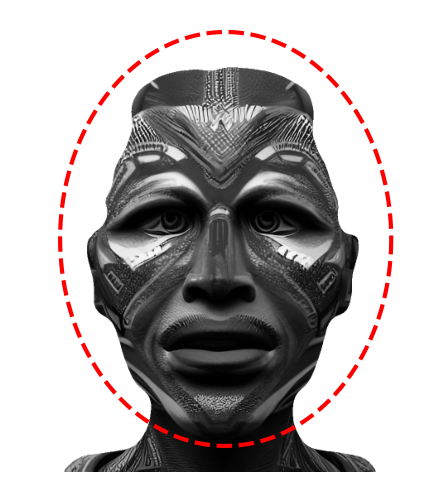

In [8]:

# image_center = (int(image.shape[0]/2), int(image.shape[1]/2))
# x_offset = 0
# y_offset = 0.08 * image.shape[1]
# x_rad = image.shape[0]*0.26
# y_rad = image.shape[1]*0.3

# points = ellipse_points(400, (image_center[0] + x_offset, image_center[1] - y_offset), x_rad, y_rad )

# s = np.linspace(0, 2*np.pi, 800)
# r = 200 + 140*np.sin(s)
# c = 260 + 130*np.cos(s)
# points = np.array([r, c]).T

# s = np.linspace(0, 2*np.pi, 800)
# r = 280 + 180*np.sin(s)
# c = 260 + 130*np.cos(s)
# points = np.array([r, c]).T   #nafees

s = np.linspace(0, 2*np.pi, 800)
r = 230 + 250*np.sin(s)
c = 260 + 200*np.cos(s)
points = np.array([r, c]).T   #1

fig, ax = image_show(image_gray)
ax.plot(points[:, 1], points[:, 0], '--r', lw=3)


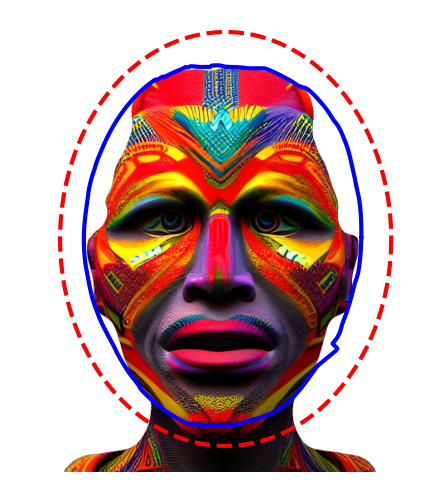

In [9]:
# beta = 5 #contour smoothness factor
# alpha = 0.1 #contour contraction speed factor
beta = 500
alpha = 0.01

snake = seg.active_contour(image_gray, points, alpha=alpha, beta=beta, gamma=0.001)

fig, ax = image_show(image_rgba)
ax.plot(points[:, 1], points[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)

In [10]:
print(snake.shape)

path = plt_path.Path(snake)

coords = np.zeros((image_gray.size,2))
for j in range(image_gray.shape[1]):
    for i in range(image_gray.shape[0]):
        coords[i+j*image_gray.shape[0]][0] = i
        coords[i+j*image_gray.shape[0]][1] = j

bool_array = path.contains_points(coords)

(800, 2)


In [11]:
png = np.copy(image_rgba)
for j in range(png.shape[1]):
    for i in range(png.shape[0]):
        if bool_array[i+j*png.shape[0]] ==  False:
            png[i,j,3] = 0
        

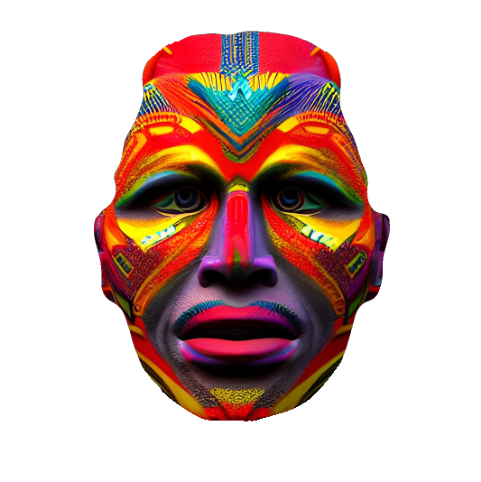

In [12]:
image_show(png)
io.imsave(f'./done{name}.png',png)